# Simple use case example of Amazon's Chronos timeseries forecasting package
This notebook demonstrates a very simple use-case of Amazon's Chronos timeseries forecasting model. This model uses LLM architecture and applies it to timeseries forecasting. Pre-trained models are available for download. The model scales and quantizes floating point timeseries data, then tokenizes the binned data to leverage the LLM architecture. Models are pre-trained on publicly available timeseries data and synthesized data.  

Here, I'm downloading stream flow data from the USGS API and attempting to forecast future stream flow values. I'm specifically using the streamflow data from the Snoqualmie River in Snoqualmie, WA (site ID 12144500) since this is a fairly major river that should have fairly strong seasonal flow variations. There do appear to be very large, transient fluctutations due to weather events which will presumably be very difficult for the model to predict without access to weather data. I found that these transients were much larger in smaller tributaries. They would presumably be less prevalent in larger bodies of water (e.g. the Columbia River).

I'm curious how well the model can capture seasonal variations in the data to make future predictions. Given the relatively short context of the model (512 tokens), I suspect that it will likely struggle to leverage the longer-term periodic patterns in the data which is sampled daily. It may be necessary to generate predictions on binned average data over weeks or months to overcome this limitation.

## Imports

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm

from datetime import timedelta

import numpy as np
import os
import seaborn as sns
from tqdm import tqdm

from chronos import ChronosPipeline
import torch

/home/ubuntu/miniconda/envs/chronos/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions
All functions saved here for convenience

In [2]:
def fetch_usgs_data(site_code, start_date, end_date):
    """
    Fetch USGS discharge data for a given site and date range.

    Args:
        site_code: (str) The USGS site code for the stream gauge
        start_date: (str) The start date in the format 'YYYY-MM-DD'
        end_date: (str) The end date in the format 'YYYY-MM-DD'

    Returns:
        (pd.DataFrame) A DataFrame with the date and discharge in cubic feet per second,
        including columns for day_of_year and year_number
    """
    base_url = "https://waterservices.usgs.gov/nwis/dv/"
    
    params = {
        "format": "json",
        "sites": site_code,
        "startDT": start_date,
        "endDT": end_date,
        "parameterCd": "00060",  # Code for discharge in cubic feet per second
        "siteStatus": "all"
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        
        # Extract time series data
        time_series = data['value']['timeSeries'][0]['values'][0]['value']
        
        # Convert to DataFrame
        df = pd.DataFrame(time_series)
        df['date'] = pd.to_datetime(df['dateTime'])
        df['value'] = pd.to_numeric(df['value'])
        df = df[['date', 'value']].set_index('date')
        df.columns = ['discharge_cfs']

        # add day_of_year and year_number colums
        df['day_of_year'] = df.index.dayofyear
        df['year_number'] = df.index.year - df.index.year.min()
        
        return df
    else:
        print(f"Error fetching data: {response.status_code}")
        return None
    
def plot_data(data, start_date=None, end_date=None):
    """
    Plot stream discharge data for a specific date range.

    Args:
        data: (pd.DataFrame) A DataFrame with a 'date' index and a 'discharge_cfs' column
        start_date: (str, optional) The start date in the format 'YYYY-MM-DD'
        end_date: (str, optional) The end date in the format 'YYYY-MM-DD'

    Returns:
        (tuple) A matplotlib figure and axis object
    """

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 6))

    # get the data to plot from the date range
    if start_date is None:
        start_date = data.index.min()
    if end_date is None:
        end_date = data.index.max()
    data_to_plot = data.loc[start_date:end_date]

    # Plot the data
    ax.plot(data_to_plot.index, data_to_plot['discharge_cfs'])

    # Set the title and labels
    ax.set_title('Stream Discharge Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Discharge (cubic feet per second)')

    # Format the x-axis to show dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    # Add a grid for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    fig.tight_layout()

    return fig, ax

def plot_data_as_array(data, cmap='magma', vmin=None, vmax=None):
    """
    Plot streamflow data as an array with years vertically and days horizontally.

    Args:
        data: (pd.DataFrame) A DataFrame with columns for discharge_cfs, year_number, and day_of_year
        cmap: (str, optional) Colormap to use for the plot
        vmin: (float, optional) Minimum value for color scaling
        vmax: (float, optional) Maximum value for color scaling

    Returns:
        (tuple) A matplotlib figure and axis object
    """
    # Define the number of days as 366 to deal with leap years
    days = 366

    # Get the number of years in the data
    years = data['year_number'].max() + 1

    # Create an array to hold the streamflow data
    streamflow_array = np.full((days, years), np.nan)

    # Fill the array with data
    for _, row in data.iterrows():
        day = int(row['day_of_year']) - 1  # 0-based index
        year = int(row['year_number'])
        streamflow_array[day, year] = row['discharge_cfs']

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    if vmin is None:
        vmin = np.nanmin(streamflow_array)
    if vmax is None:
        vmax = np.nanmax(streamflow_array)

    # Plot the streamflow array as an image
    im = ax.imshow(
        streamflow_array.T, 
        aspect='auto', 
        origin='lower', 
        extent=[1, 366, 0, years], 
        cmap=cmap, 
        norm=LogNorm(vmin=vmin, vmax=vmax),
        interpolation='none',
    )

    # Customize the plot
    ax.set_title('Streamflow Patterns Across Years')
    ax.set_ylabel('Year')
    ax.set_xlabel('Day of Year')

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, label='Discharge (cubic feet per second)')

    # Set x-ticks to show actual years
    years_range = range(data.index.year.min(), data.index.year.max() + 1)
    ax.set_yticks(np.arange(years) + 0.5)
    ax.set_yticklabels(years_range, rotation=0, ha='right')

    # Set y-ticks to show months
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_positions = [15, 45, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]
    ax.set_xticks(month_positions)
    ax.set_xticklabels(months)
    
    fig.tight_layout()

    return fig, ax

def get_forecast_dataframe(input_date, num_samples, prediction_length, pipeline, data):
    """
    Generate a forecast dataframe using the provided pipeline and data.

    Args:
        input_date: (str or datetime) The start date for the forecast
        num_samples: (int) The number of forecast samples to generate
        prediction_length: (int) The number of days to forecast
        pipeline: (object) The forecasting pipeline object
        data: (pd.DataFrame) The historical data used for forecasting

    Returns:
        (pd.DataFrame) A dataframe containing the forecast data with columns for date, 
        predicted_flow, forecast_day, and prediction_number
    """

    # Convert input_date to datetime if it's a string
    if isinstance(input_date, str):
        input_date = pd.to_datetime(input_date)

    # Generate forecast
    # Use .loc to select data up to input_date, then select 'discharge_cfs' column
    context_data = data.loc[:input_date, 'discharge_cfs']
    forecast = pipeline.predict(
        context=torch.tensor(context_data.values),
        prediction_length=prediction_length,
        num_samples=num_samples,
        limit_prediction_length=False,
    )

    # Initialize lists to store data
    dates = []
    predicted_flows = []
    forecast_days = []
    prediction_numbers = []

    # Process the forecast tensor
    for sample in range(num_samples):
        for day in range(prediction_length):
            dates.append(input_date + timedelta(days=day+1))
            predicted_flows.append(forecast[0, sample, day].item())
            forecast_days.append(day + 1)  # Start from 1 instead of 0
            prediction_numbers.append(sample)

    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'predicted_flow': predicted_flows,
        'forecast_day': forecast_days,
        'prediction_number': prediction_numbers
    })

    # Ensure 'date' is datetime type and set as index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    return df


def calculate_historical_median(data):
    """
    Calculate the historical median discharge for each day of the year.

    Args:
        data: (pd.DataFrame) A DataFrame with a datetime index and 'discharge_cfs' column

    Returns:
        (pd.Series) A series with the historical median discharge for each day of the year
    """
    # Create a copy of the data to avoid modifying the original
    data_copy = data.copy()
    
    # Add day of year column
    data_copy['day_of_year'] = data_copy.index.dayofyear
    
    # Group by day of year and calculate mean
    historical_median = data_copy.groupby('day_of_year')['discharge_cfs'].median()
    
    # Function to map day of year to the average
    def get_historical_median(date):
        return historical_median[date.dayofyear]
    
    # Apply the function to all dates in the original data
    historical_median_series = data.index.to_series().apply(get_historical_median)
    historical_median_series.index = data.index
    
    return historical_median_series


def plot_streamflow_forecast(data, forecast_df, history_to_plot):
    """
    Plot a streamflow forecast including historical data, forecast, and confidence interval.

    Args:
        data: (pd.DataFrame) Historical streamflow data
        forecast_df: (pd.DataFrame) Forecast data generated by get_forecast_dataframe
        history_to_plot: (int) Number of historical days to include in the plot

    Returns:
        (tuple) A matplotlib figure and axis object
    """
    # Infer date from forecast_df
    date = forecast_df.index.min() - timedelta(days=1)  # Assuming forecast starts day after input_date
    
    # Calculate historical average (assuming this function exists)
    historical_median = calculate_historical_median(data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot historical data
    historical_data = data[data.index >= date - timedelta(days=history_to_plot)]
    historical_data = historical_data[historical_data.index <= date]
    ax.plot(historical_data.index, historical_data['discharge_cfs'], color='black', label=f'Actual flow over past {history_to_plot} days')
    
    # Plot historical average
    historical_avg_plot = historical_median[historical_median.index.isin(historical_data.index) | 
                                            historical_median.index.isin(forecast_df.index)]
    ax.plot(historical_avg_plot.index, historical_avg_plot.values, color='blue', linestyle='--', label='Historical Average')
    
    # Plot forecast using Seaborn with confidence interval
    sns.lineplot(
        data=forecast_df,
        x=forecast_df.index,
        y='predicted_flow',
        color='red',
        ax=ax,
        label='Forecast',
        errorbar=('ci', 95),
    )
    
    # Plot actual future data if it exists
    future_data = data[data.index > date]
    if not future_data.empty:
        ax.plot(future_data.index, future_data['discharge_cfs'], color='gray', label='Actual Future Data')
    
    # Customize the plot
    ax.set_title(f'Streamflow Forecast from {date.date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Discharge (cubic feet per second)')
    ax.legend()
    
    # Format x-axis to show dates nicely
    fig.autofmt_xdate()
    
    # Add grid for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Set x-axis limits
    ax.set_xlim(date - timedelta(days=history_to_plot), forecast_df.index.max())
    
    plt.tight_layout()

    return fig, ax

def get_and_plot_forecast(data, date, num_samples, prediction_length, history_to_plot, pipeline):
    """
    Generate and plot a streamflow forecast.

    Args:
        data: (pd.DataFrame) Historical streamflow data
        date: (str or datetime) The start date for the forecast
        num_samples: (int) The number of forecast samples to generate
        prediction_length: (int) The number of days to forecast
        history_to_plot: (int) Number of historical days to include in the plot
        pipeline: (object) The forecasting pipeline object

    Returns:
        (tuple) A matplotlib figure, axis object, and the forecast dataframe
    """
    # Get forecast
    forecast_df = get_forecast_dataframe(date, num_samples, prediction_length, pipeline, data)
    
    # Plot forecast
    fig, ax = plot_streamflow_forecast(data, forecast_df, history_to_plot)
    
    return fig, ax, forecast_df

def get_cache_path(cache_filename):
    """
    Generate the full path for the cache file in the user's home directory.

    Args:
        cache_filename: (str) The name of the cache file

    Returns:
        (str) The full path to the cache file in the user's home directory
    """
    return os.path.join(os.path.expanduser("~"), cache_filename)

def get_cached_data(cache_filename):
    """
    Retrieve the cached dataframe from a file.

    Args:
        cache_filename: (str) The name of the cache file

    Returns:
        (pd.DataFrame) The cached dataframe if it exists, otherwise an empty dataframe
    """
    cache_file = get_cache_path(cache_filename)
    if os.path.exists(cache_file):
        return pd.read_csv(cache_file, parse_dates=['prediction_date'], index_col='prediction_date')
    return pd.DataFrame()

def save_cached_data(df, cache_filename):
    """
    Save the dataframe to a cache file.

    Args:
        df: (pd.DataFrame) The dataframe to be cached
        cache_filename: (str) The name of the cache file

    Returns:
        None
    """
    cache_file = get_cache_path(cache_filename)
    df.to_csv(cache_file)

def generate_single_prediction(input_date, num_samples, prediction_length, data, cache_filename, pipeline):
    """
    Generate a single prediction for a given input date, using caching if available.

    Args:
        input_date: (datetime) The date for which to generate the prediction
        num_samples: (int) The number of forecast samples to generate
        prediction_length: (int) The number of days to forecast
        data: (pd.DataFrame) The historical data used for forecasting
        cache_filename: (str) The name of the cache file
        pipeline: (object) The forecasting pipeline object

    Returns:
        (dict) A dictionary containing the prediction date and forecast values for each day,
        or None if the input date is not in the data
    """
    cache_df = get_cached_data(cache_filename)
    
    # Check if the prediction for this date is already cached
    if input_date in cache_df.index:
        result = cache_df.loc[input_date].to_dict()
        result['prediction_date'] = input_date  # Ensure prediction_date is always included
        return result

    # Check if the input_date exists in the data
    if input_date not in data.index:
        return None

    # Get the actual value for day_0
    actual_value = data.loc[input_date, 'discharge_cfs']

    # Generate forecast
    forecast_df = get_forecast_dataframe(
        input_date=input_date,
        num_samples=num_samples,
        prediction_length=prediction_length,
        pipeline=pipeline,
        data=data
    )

    # Calculate median predictions
    median_predictions = forecast_df.groupby('forecast_day')['predicted_flow'].median()

    # Create a row for the result dataframe
    result = {
        'prediction_date': input_date,
        'day_0': actual_value
    }
    for day, value in median_predictions.items():
        result[f'day_{day}'] = value

    return result

def generate_predictions(start_date, end_date, num_samples, prediction_length, pipeline, data, cache_filename):
    """
    Generate predictions for a range of dates, using caching to avoid redundant calculations.

    Args:
        start_date: (str or datetime) The start date for generating predictions
        end_date: (str or datetime) The end date for generating predictions
        num_samples: (int) The number of forecast samples to generate
        prediction_length: (int) The number of days to forecast
        pipeline: (object) The forecasting pipeline object
        data: (pd.DataFrame) The historical data used for forecasting
        cache_filename: (str) The name of the cache file

    Returns:
        (pd.DataFrame) A dataframe containing predictions for the specified date range
    """
    # Create a list of dates to predict
    date_range = pd.date_range(start=start_date, end=end_date)

    # Get existing cache
    cache_df = get_cached_data(cache_filename)

    results = []

    # Serial execution with progress bar
    for date in tqdm(date_range, desc="Generating Predictions"):
        result = generate_single_prediction(date, num_samples, prediction_length, data, cache_filename, pipeline)
        if result is not None:
            results.append(result)

    # If all predictions were cached, return the cached data for the requested date range
    if not results:
        return cache_df.loc[start_date:end_date]

    # Convert results to dataframe
    result_df = pd.DataFrame(results)
    
    # Ensure 'prediction_date' is in the columns
    if 'prediction_date' not in result_df.columns:
        print("Warning: 'prediction_date' not found in results. Using index as prediction_date.")
        result_df['prediction_date'] = result_df.index

    result_df.set_index('prediction_date', inplace=True)

    # Merge with existing cache
    result_df = pd.concat([cache_df, result_df]).drop_duplicates()

    # Ensure columns are in the correct order (day_0, day_1, day_2, ...)
    cols = ['day_0'] + [f'day_{i}' for i in range(1, prediction_length + 1)]
    result_df = result_df.reindex(columns=cols)

    # Ensure the index is sorted
    result_df = result_df.sort_index()

    # Find the nearest existing dates
    actual_start = result_df.index[result_df.index >= pd.to_datetime(start_date)][0]
    actual_end = result_df.index[result_df.index <= pd.to_datetime(end_date)][-1]

    # Save updated cache
    save_cached_data(result_df, cache_filename)

    return result_df.loc[actual_start:actual_end]

def plot_multi_horizon_forecast(predictions, forecast_days):
    """
    Plot multi-horizon forecast from the predictions dataframe.

    Args:
        predictions: (pd.DataFrame) DataFrame with dates as index and day_0, day_1, ..., day_N as columns
        forecast_days: (list) List of forecast horizons to plot (e.g., [1, 5, 10])

    Returns:
        (tuple) A matplotlib figure and axis object
    """
    # Ensure forecast days are sorted
    forecast_days = sorted(forecast_days)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot current values (day_0)
    ax.plot(predictions.index, predictions['day_0'], color='black', label='Observed Value')
    
    # Color palette for forecast lines
    colors = sns.color_palette("husl", len(forecast_days))
    
    # Plot each forecast horizon
    for i, day in enumerate(forecast_days):
        # Create a Series for this forecast horizon
        forecast_series = pd.Series(index=predictions.index[day:], 
                                    data=predictions[f'day_{day}'].values[:-day])
        
        ax.plot(forecast_series.index, forecast_series.values, 
                color=colors[i], label=f'{day}-day Forecast Value')
    
    # Customize the plot
    ax.set_title('Multi-Horizon Streamflow Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Discharge (cubic feet per second)')
    ax.legend()
    
    # Format x-axis to show dates nicely
    fig.autofmt_xdate()
    
    # Add grid for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    return fig, ax

## Get data for the Snoqualmie River using the USGS API

In [3]:
site_code = "12144500"  # Snoqualmie River Near Snoqualmie, WA - 12144500
start_date = "1950-01-01" # This is earlier than the earliest recording date. This will get all historical data
end_date = "2024-08-29"

data = fetch_usgs_data(site_code, start_date, end_date)

data

,discharge_cfs,day_of_year,year_number
date,,,
1958-09-01,412.0,244,0
1958-09-02,662.0,245,0
1958-09-03,402.0,246,0
1958-09-04,348.0,247,0
1958-09-05,343.0,248,0
...,...,...,...
2024-08-25,1250.0,238,66
2024-08-26,914.0,239,66
2024-08-27,833.0,240,66


## Plot the data over a couple timescales
It's clearly periodic, but with lots of transients that presumably the result of rainfall events. I expect these to be very challenging for the model to predict.

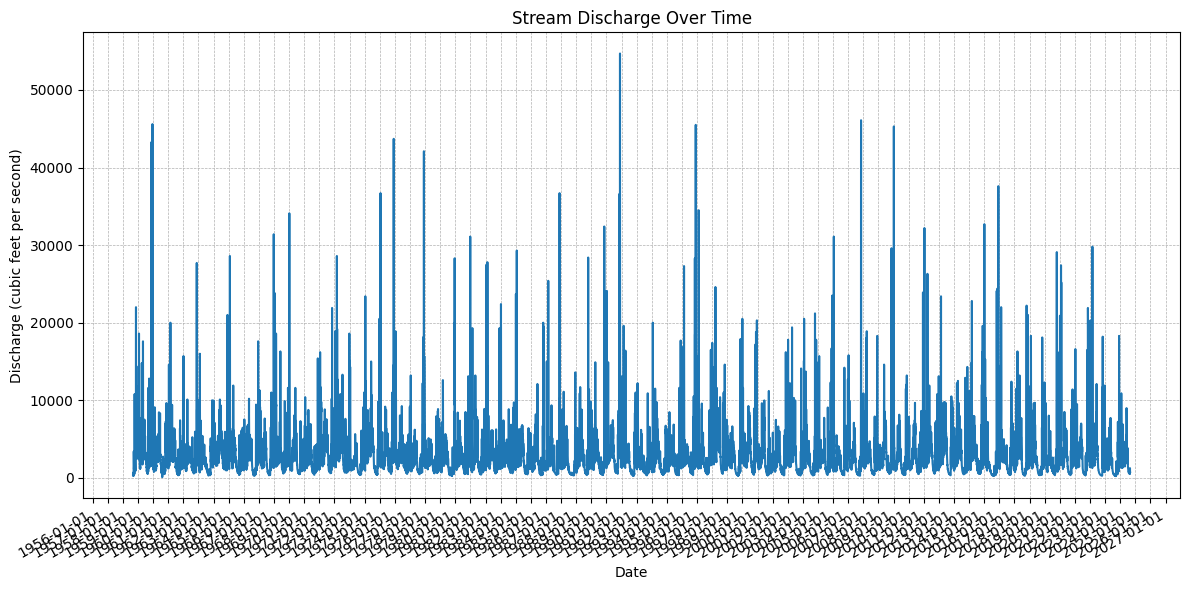

In [4]:
plot_data(data);

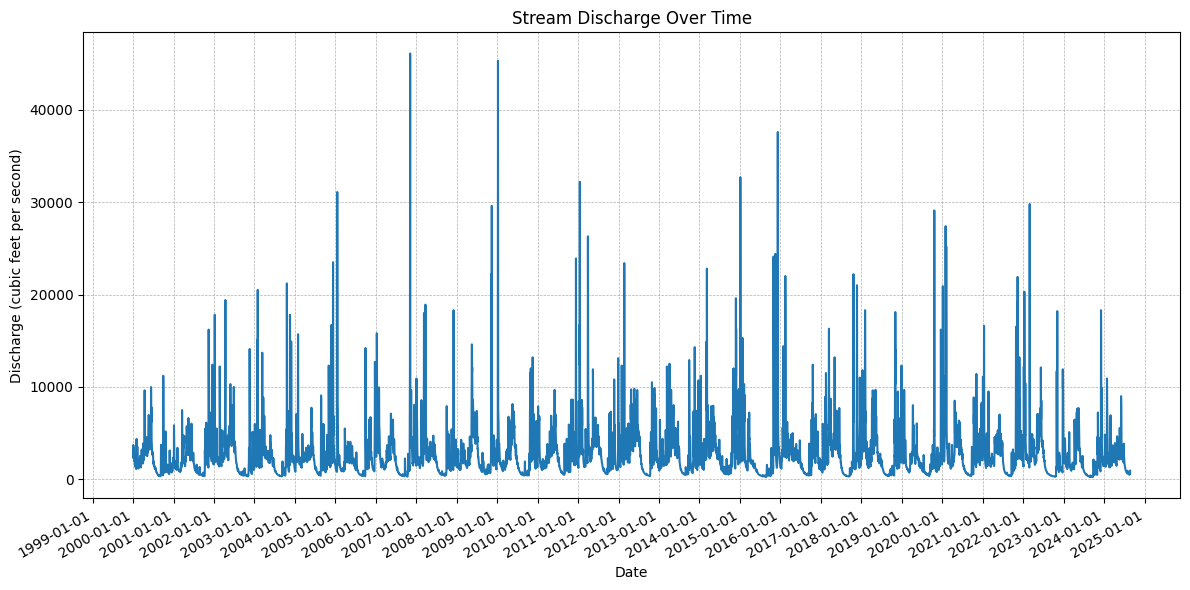

In [5]:
plot_data(data, start_date='2000-01-01', end_date='2024-08-24');

## Plot the data as an array
This better demonstrates the periodicity. But also demonstrates yearly differences in timing of the seasonal extremes. This will likely be challenging for the model.

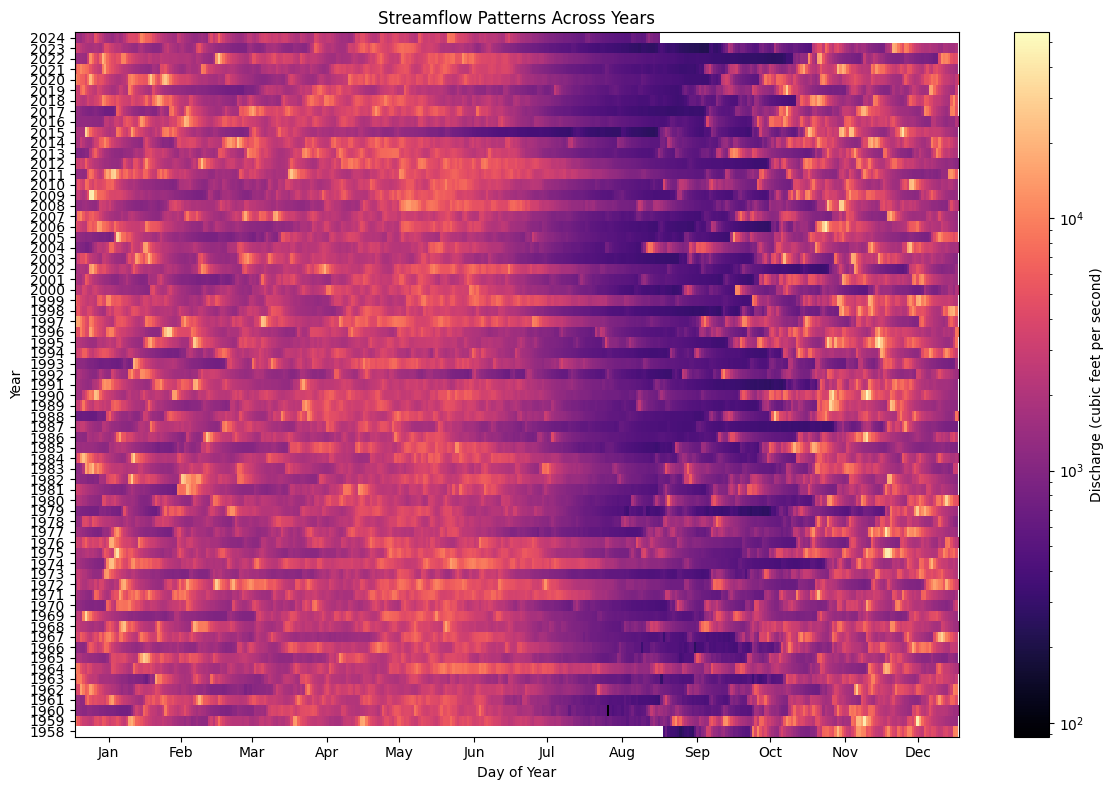

In [6]:
plot_data_as_array(data);

Plot again with defined ranges to better emphasize the differences across years (avoiding letting extreme mins/maxes define the range)

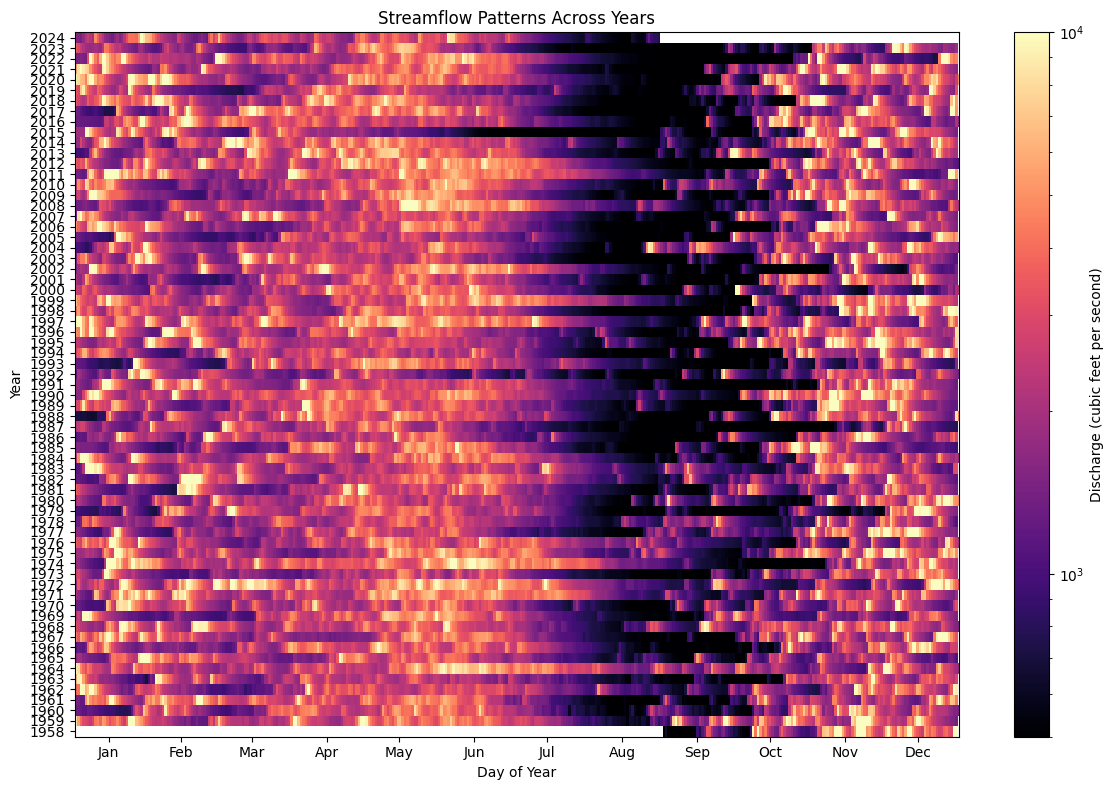

In [7]:
plot_data_as_array(data, vmin=500, vmax=10000);

## Plot the average for each day with 95% confidence intervals. This better demonstrates the seasonal pattern

<Axes: xlabel='day_of_year', ylabel='discharge_cfs'>

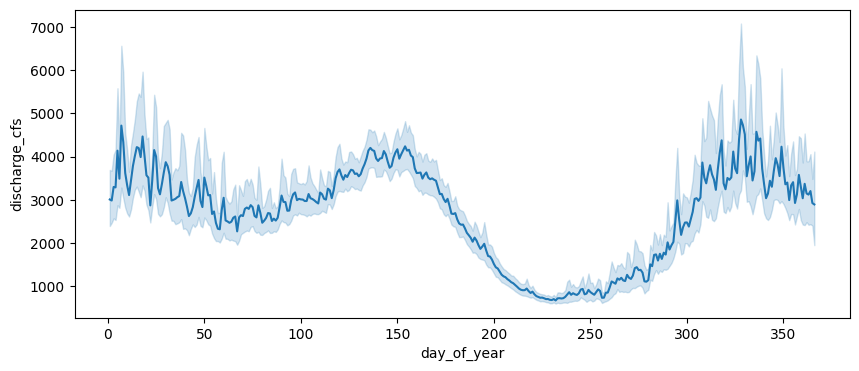

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    data = data,
    x='day_of_year',
    y='discharge_cfs',
    ax=ax,
)

## Now start forecasting!
The authors provide a nice pipeline class that performs all of the scaling, quantizing, tokenization, prediction, and decoding. 

I'm going to try out the "small", "base" and "large" models to see how differently they perform.

In [9]:
pipeline_small = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [10]:
pipeline_base = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [11]:
pipeline_large = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

### Generate and plot some forecasts for specific dates
The models (all sizes) seem to do a reasonable job of following seasonal trends, but clearly cannot predict future transients, which is expected given that there's no way for the models to anticipate rainfall.

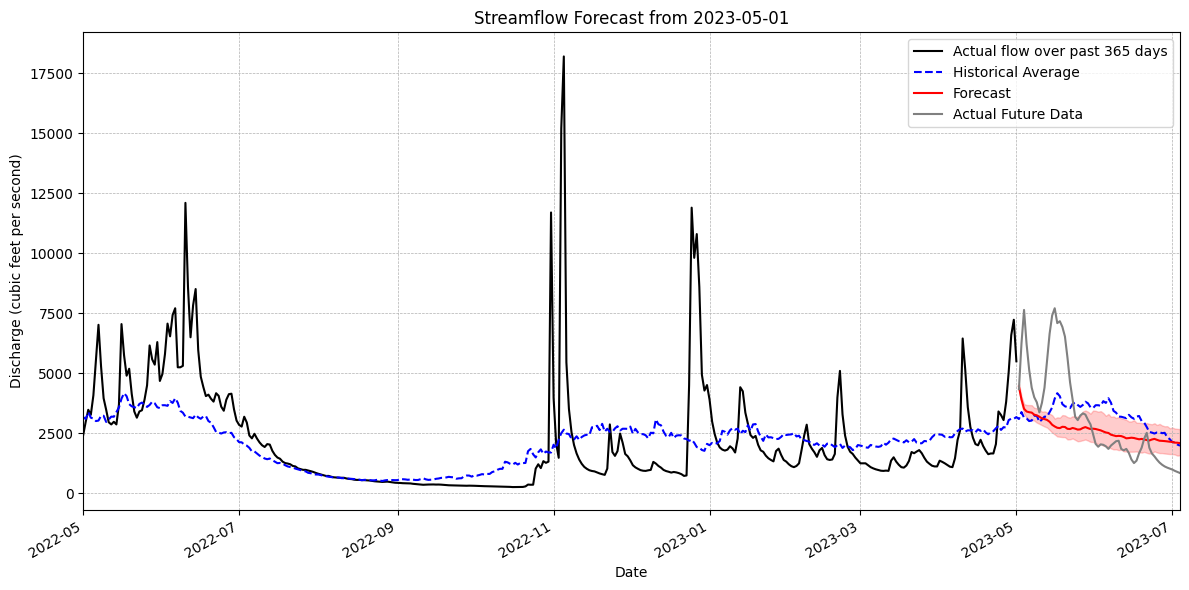

In [12]:
forecast_df = get_forecast_dataframe(
    input_date='2023-05-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_small, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)

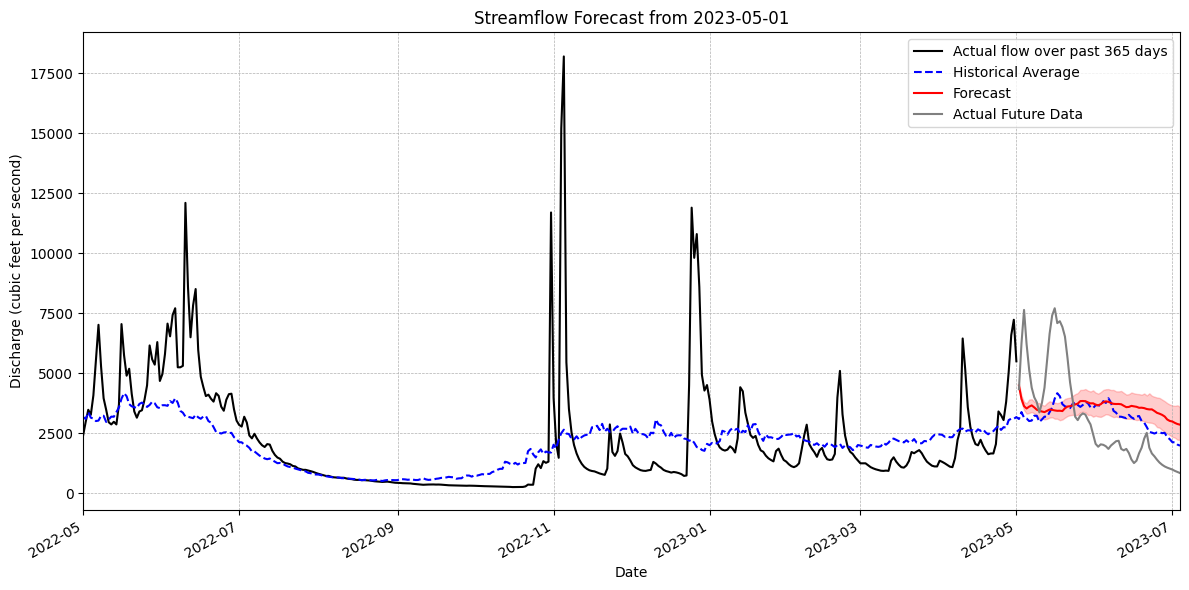

In [13]:
forecast_df = get_forecast_dataframe(
    input_date='2023-05-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_base, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)


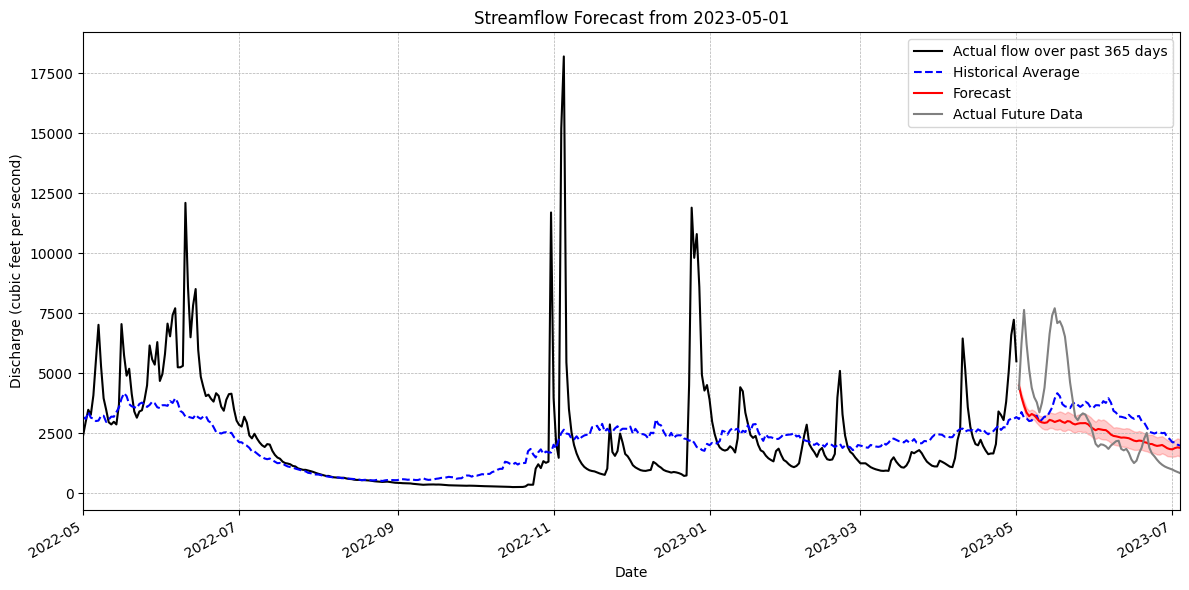

In [14]:
forecast_df = get_forecast_dataframe(
    input_date='2023-05-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_large, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)


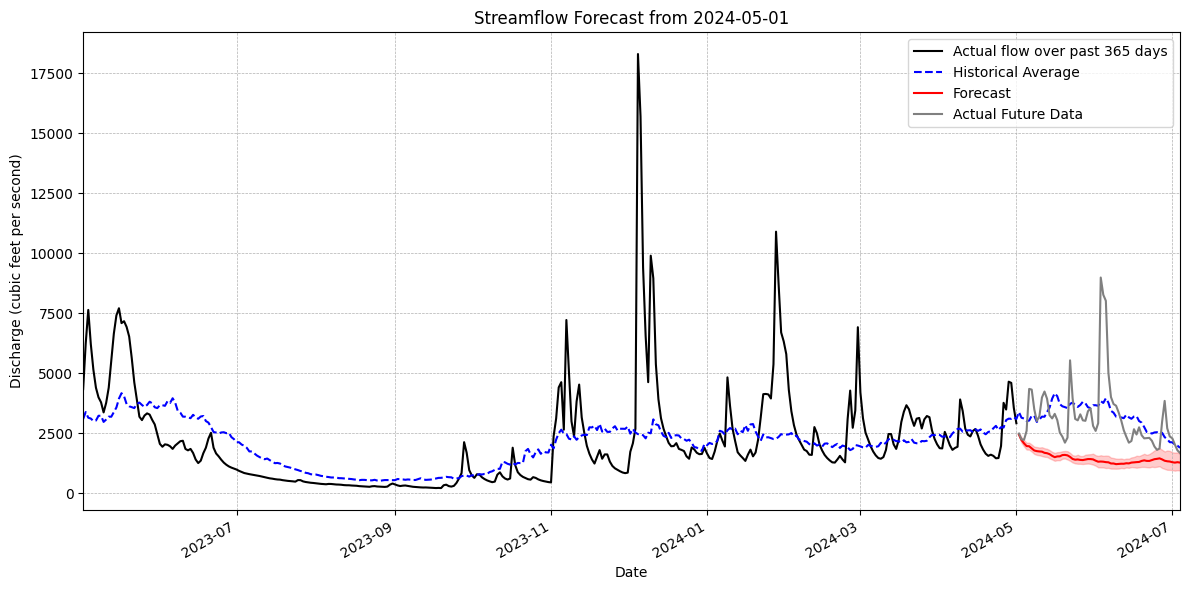

In [15]:
forecast_df = get_forecast_dataframe(
    input_date='2024-05-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_large, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)


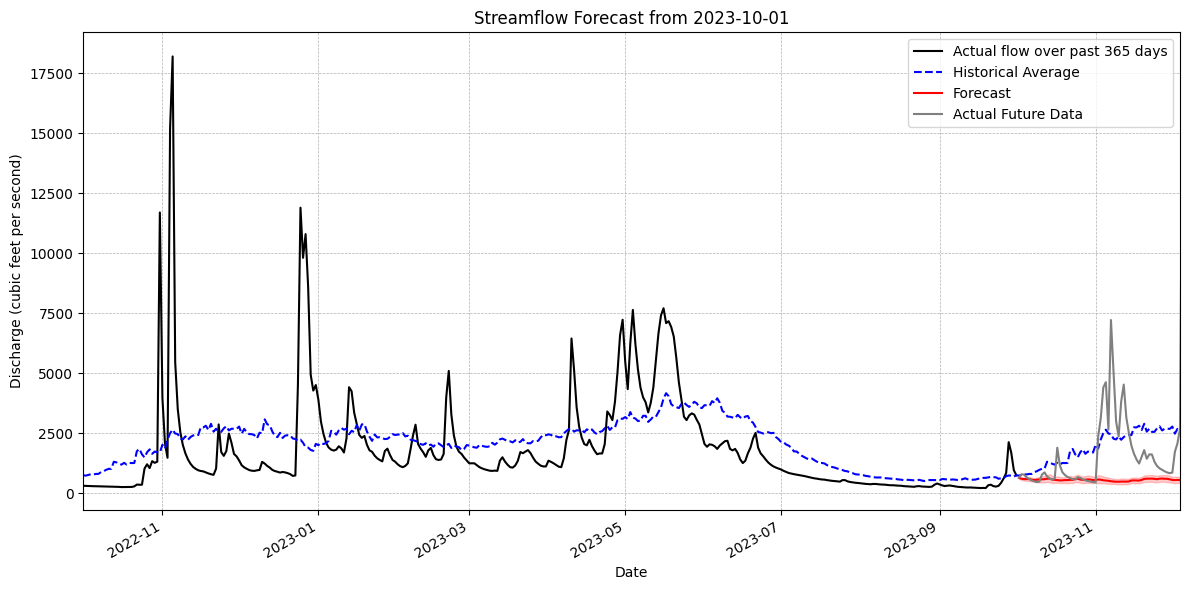

In [16]:
forecast_df = get_forecast_dataframe(
    input_date='2023-10-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_large, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)

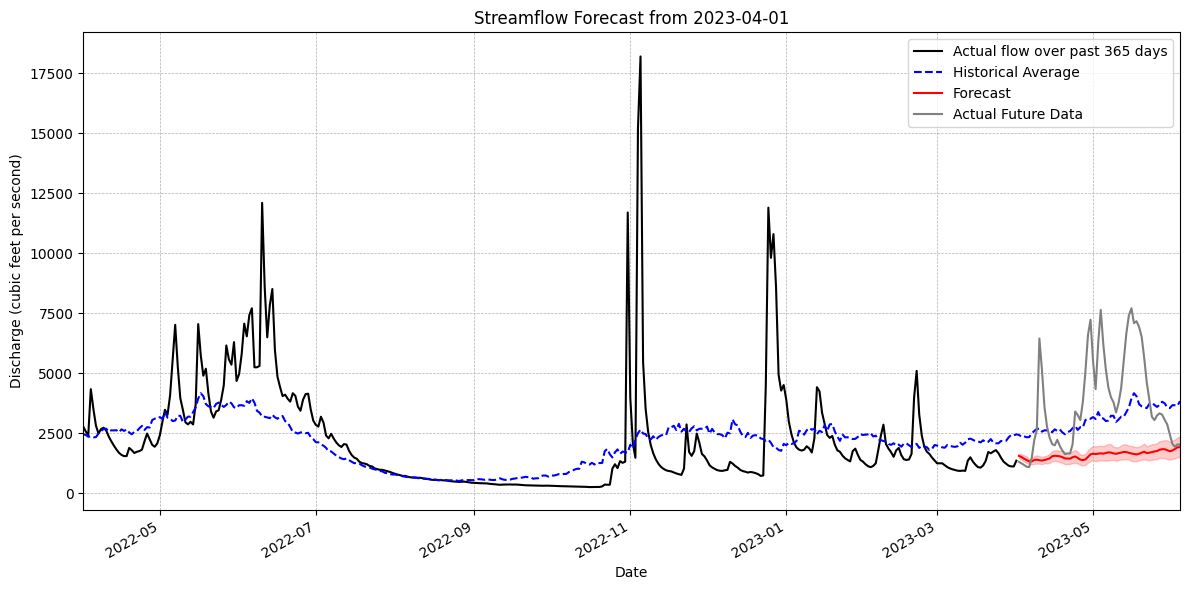

In [17]:
forecast_df = get_forecast_dataframe(
    input_date='2023-04-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_large, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)

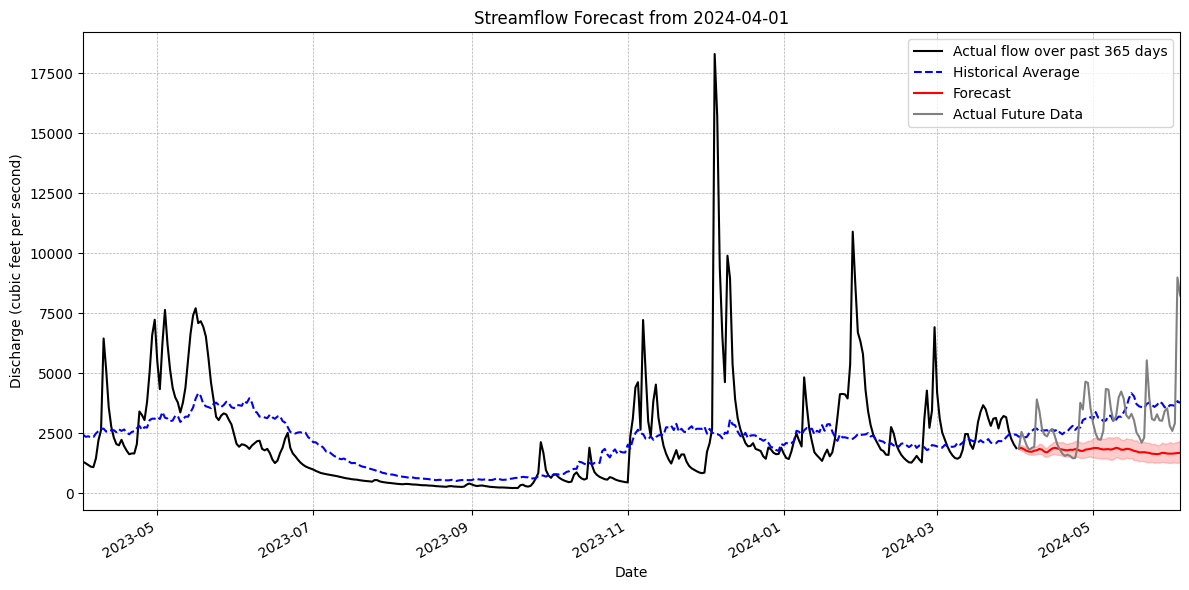

In [18]:
forecast_df = get_forecast_dataframe(
    input_date='2024-04-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_large, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)

## Now generate some predictions for every day in a multi-month interval from 4/1/24 to 8/24/24
This will let us see how well the actual data compares to predictions over various lengths of time.  
Note that I'm caching the predictions locally to avoid having to run inference multiple times for the same date. The function below will execute much faster the second time it is run.

In [19]:
predictions = generate_predictions(
    start_date='2024-01-01',
    end_date='2024-08-29',
    num_samples=30,
    prediction_length=64,
    data=data,
    cache_filename='forecast_cache_large.csv',
    pipeline=pipeline_large
)

predictions

Generating Predictions:   8%|▊         | 19/242 [00:00<00:01, 180.46it/s]

Generating Predictions: 100%|██████████| 242/242 [00:30<00:00,  8.03it/s] 


,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_55,day_56,day_57,day_58,day_59,day_60,day_61,day_62,day_63,day_64
prediction_date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,1660.0,1533.375805,1520.099837,1420.529970,1301.046150,1241.304187,1174.924347,1174.924347,1155.010288,1208.114267,...,829.748804,823.110820,889.490714,862.938751,836.386788,929.318644,849.662783,836.386815,816.472809,783.282862
2024-01-02,1470.0,1388.555029,1328.760797,1229.103727,1215.816132,1195.884739,1222.459929,1249.035119,1249.035119,1175.953346,...,1029.789585,1016.501990,1023.145788,1029.789639,1043.077180,996.570598,1069.652478,1096.227668,1076.296276,1136.090453
2024-01-03,1430.0,1429.618524,1422.969142,1329.877687,1329.877687,1356.475215,1329.877687,1356.475269,1289.981395,1230.136849,...,851.121700,837.822936,797.926617,777.978472,771.329090,811.225408,857.771109,891.018046,1024.005793,1037.304557
2024-01-04,1740.0,1670.955272,1511.182649,1404.667567,1371.381584,1324.781283,1351.410026,1284.838113,1278.180928,1284.838113,...,1011.893223,1011.893223,971.950054,938.664125,965.292922,998.578851,985.264480,971.950108,951.978550,925.349699
2024-01-05,2170.0,2007.096991,1773.713630,1647.019815,1526.994089,1580.338808,1533.662179,1433.640723,1580.338808,1433.640669,...,940.201588,926.865408,900.192995,873.520635,840.180132,860.184428,853.516339,846.848249,893.524878,886.856815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-25,1250.0,1158.204687,1037.558324,908.868947,844.524243,836.481130,836.481163,876.696562,860.610402,796.265698,...,699.748673,723.877913,715.834833,675.619368,651.490128,675.619368,635.403968,635.403968,691.705593,667.576288
2024-08-26,914.0,755.783725,691.461767,651.260478,643.220234,627.139744,611.059189,594.978700,570.857966,546.737199,...,546.737199,538.696937,506.535926,482.415175,490.455420,498.495681,458.294425,474.374930,466.334669,466.334669
2024-08-27,833.0,787.652188,763.540377,747.465826,739.428567,795.689447,763.540377,739.428567,691.204979,675.130461,...,755.503085,707.279530,675.130428,659.055909,594.757803,634.944132,651.018650,667.093201,634.944099,610.832289


### Now plot the predictions over various time horizons
In the plot below, the black line represents the actual observed data. Each colored line represents the forecast for that day that was generated N days ago. For example, the 10-day forecast represents the forecast ten days into future using data up to and including ten days prior.  

Note that the 1-day forecast does a reasonable job of anticipating short term transients. If the level was rapidly rising/falling on a given day, it seems to do a decent job of predicting subsequent patterns. 5 and 10 day forecasts miss the transients, but seem to capture the seasonal trend reasonably well (predicting a prolonged summer dry spell). 30 and 60 day forecasts seem totally useless.

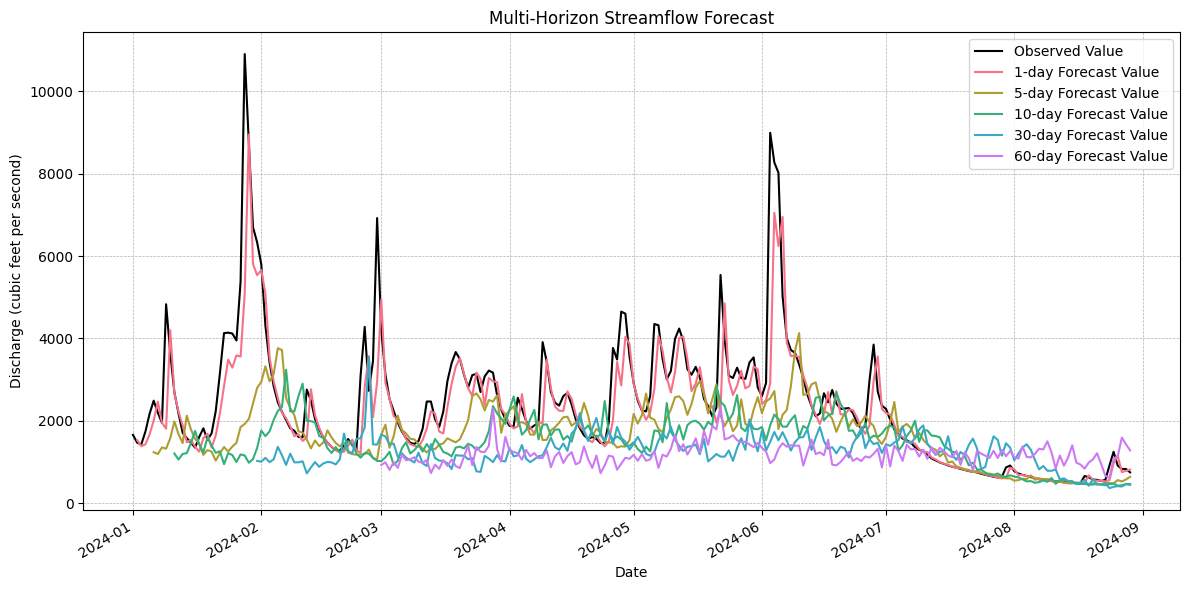

In [20]:
fig, ax = plot_multi_horizon_forecast(predictions, forecast_days=[1, 5, 10, 30, 60])
plt.show()

## Wrapup
The model is quite easy to download and use for inference, but the results aren't too impressive. I suspect a big part of this is due to the relatively short context of only 512 tokens. Since I'm using data sampled daily, the model is only able to leverage about a year and a half of previous data when performing inference on a given day. It might be more useful to group by week and/or month, which would allow the model's context window to take in multiple years of data, allowing it to leverage more of the seasonal variations when making predictions. This would also have the advantage of smoothing out the short term effects of weather-related transients.

There also seems to be a lot of potential for using this basic framework to do timeseries forecasting with a longer context window. This would open up the possibility of doing forecasting on more densely sampled timeseries, potentially including audio data with kilohertz sampling rates. This would require quite a lot more training data and some nontrivial GPU resources, but would be a fun project to explore.